In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler
import GDPRDataset
import text_preprocessing as tp
import sklearn.svm as svm
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import json
import numpy as np
from pathlib import Path
from joblib import dump, load
import matplotlib.pyplot as plt

In [2]:
# Load config for this application
config_file = open(f"{str(Path.cwd())}/test_svm_config.json")
config = json.load(config_file)
config_file.close()

In [3]:
df_train = GDPRDataset.GDPRDataset(dataset_dir=config['train_dataset_path']).dataframe
df_test = GDPRDataset.GDPRDataset(dataset_dir=config['test_dataset_path']).dataframe

In [4]:
documents= df_train['content'].to_list()
tfidf_svm_train = pd.read_json(config['svm_training_set_v1_path'])

In [5]:
# build TF-IDF vectorizer
german_stop_words = stopwords.words('german')
tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words=german_stop_words)

fit_tfidf_documents = tp.clean_german_texts(documents)
tfidf_vectorizer.fit_transform(fit_tfidf_documents)

# train or load SVM
train_texts = tfidf_svm_train['text'].values
train_texts = tp.clean_german_texts(train_texts)
train_text_vectors = tfidf_vectorizer.transform(train_texts)
rbX = RobustScaler(with_centering=False)
train_text_vectors_norm = rbX.fit_transform(train_text_vectors)

train_labels = tfidf_svm_train['is_GDPR'].values
SVM = svm.SVC(C=1, kernel='rbf', degree=3, gamma='auto', probability=True)
SVM.fit(train_text_vectors_norm, train_labels)

SVC(C=1, gamma='auto', probability=True)

In [7]:
type(tfidf_vectorizer.vocabulary_)

dict

In [13]:
tfidf_vectorizer.vocabulary_

{'checkup': 2402,
 'mail': 8247,
 'search': 11460,
 'hom': 6223,
 'warum': 14353,
 'find': 4618,
 'biet': 1862,
 'kostenoptimier': 7470,
 'controlling': 2617,
 'erp': 4127,
 'system': 12559,
 'nutz': 9339,
 'uberzeug': 13240,
 'beispiel': 1487,
 'gold': 5593,
 'regeln': 10740,
 'netzwerk': 9153,
 'mitgliedschaft': 8770,
 'partn': 9692,
 'praxis': 10086,
 'kontakt': 7369,
 'navigation': 9094,
 'expert': 4305,
 'edv': 3526,
 'gestutzt': 5454,
 'optimier': 9528,
 'betriebsablauf': 1765,
 'effektiv': 3532,
 'kostenrechn': 7472,
 'hilft': 6111,
 'unternehm': 13456,
 'steu': 12288,
 'richtig': 10934,
 'entscheid': 3942,
 'treff': 13061,
 'schliess': 11283,
 'luck': 8173,
 'besteh': 1704,
 'syst': 12557,
 'it': 6798,
 'losung': 8144,
 'optimi': 9527,
 'kaufmann': 7049,
 'prozess': 10406,
 'massgeschneidert': 8431,
 'softwarelos': 11870,
 'hand': 5794,
 'scharf': 11220,
 'blick': 1942,
 'ganz': 5059,
 'detail': 3052,
 'aug': 992,
 'verli': 13790,
 'kostenberat': 7458,
 'spar': 11987,
 'zeit': 

In [12]:
sorted_vocab = list(sorted(tfidf_vectorizer.vocabulary_.items(), key=lambda item: item[1], reverse=True))
sorted_vocab

[('česká', 15219),
 ('zzgl', 15218),
 ('zylinderschloss', 15217),
 ('zyklisch', 15216),
 ('zykl', 15215),
 ('zwonitz', 15214),
 ('zwischenzon', 15213),
 ('zwischenstops', 15212),
 ('zwischendurch', 15211),
 ('zwirn', 15210),
 ('zwingend', 15209),
 ('zwickau', 15208),
 ('zwergenpow', 15207),
 ('zwergenfantasi', 15206),
 ('zwerg', 15205),
 ('zweit', 15204),
 ('zweifel', 15203),
 ('zweieinhalb', 15202),
 ('zwei', 15201),
 ('zweckmass', 15200),
 ('zweckgebund', 15199),
 ('zweckbestimm', 15198),
 ('zweck', 15197),
 ('zwangsstor', 15196),
 ('zwangslauf', 15195),
 ('zwangsjack', 15194),
 ('zwanghaft', 15193),
 ('zwang', 15192),
 ('zwack', 15191),
 ('zuzustimm', 15190),
 ('zuzurechn', 15189),
 ('zuzulass', 15188),
 ('zuzuhor', 15187),
 ('zuzugreif', 15186),
 ('zuwend', 15185),
 ('zuweis', 15184),
 ('zuvor', 15183),
 ('zuverlass', 15182),
 ('zuverla', 15181),
 ('zuverfug', 15180),
 ('zuv', 15179),
 ('zutun', 15178),
 ('zutrittskontroll', 15177),
 ('zutreff', 15176),
 ('zustimmungsstatus', 15175

In [10]:
"wabnitz-it" in sorted_vocab.values()

False

In [8]:
SVM.predict_proba(
    rbX.fit_transform(
        tfidf_vectorizer.transform(["Wir verwenden Cookies auf unserer Website. Durch die Nutzung stimmen Sie dem zu. Für weitere Informationen lesen Sie bitte unsere Datenschutzerklärung.  Zur            Datenschutzerkärung   Akze"])))

array([[0.89766657, 0.10233343]])

In [9]:
SVM.predict(
    rbX.fit_transform(
        tfidf_vectorizer.transform([
                                       "Wir verwenden Cookies auf unserer Website. Durch die Nutzung stimmen Sie dem zu. Für weitere Informationen lesen Sie bitte unsere Datenschutzerklärung.  Zur            Datenschutzerkärung   Akze"])))

array([0])

In [10]:
train_porbas = SVM.predict_proba(train_text_vectors_norm)
train_preds = [np.argmax(prob) for prob in train_porbas]
accuracy_score(train_labels, train_preds)

0.888

In [11]:
for prob, pred, label in zip(train_porbas, train_preds, train_labels):
    print("{:.4f}, {:.4f}: pred={}, y={}".format(prob[0], prob[1], pred, label))

0.7435, 0.2565: pred=0, y=1
0.4308, 0.5692: pred=1, y=1
0.0000, 1.0000: pred=1, y=1
0.0000, 1.0000: pred=1, y=1
0.0401, 0.9599: pred=1, y=1
0.0000, 1.0000: pred=1, y=1
0.0105, 0.9895: pred=1, y=1
0.4751, 0.5249: pred=1, y=1
0.0498, 0.9502: pred=1, y=1
0.8873, 0.1127: pred=0, y=1
0.6420, 0.3580: pred=0, y=1
0.1511, 0.8489: pred=1, y=1
0.0138, 0.9862: pred=1, y=1
0.3145, 0.6855: pred=1, y=1
0.0837, 0.9163: pred=1, y=1
0.0000, 1.0000: pred=1, y=1
0.0228, 0.9772: pred=1, y=1
0.0138, 0.9862: pred=1, y=1
0.1312, 0.8688: pred=1, y=1
0.0000, 1.0000: pred=1, y=1
0.0000, 1.0000: pred=1, y=1
0.0615, 0.9385: pred=1, y=1
0.8822, 0.1178: pred=0, y=1
0.8739, 0.1261: pred=0, y=1
0.6549, 0.3451: pred=0, y=1
0.2999, 0.7001: pred=1, y=1
0.0000, 1.0000: pred=1, y=1
0.0000, 1.0000: pred=1, y=1
0.0377, 0.9623: pred=1, y=1
0.8495, 0.1505: pred=0, y=1
0.0000, 1.0000: pred=1, y=1
0.0000, 1.0000: pred=1, y=1
0.0323, 0.9677: pred=1, y=1
0.0000, 1.0000: pred=1, y=1
0.3266, 0.6734: pred=1, y=1
0.6848, 0.3152: pred

In [7]:
pos_test_texts = df_test[df_test['contains_GDPR'] == True]['content_removed'].values
test_labels = tfidf_svm_train['is_GDPR']
pos_test_texts = tp.clean_german_texts(pos_test_texts)
pos_test_text_vectors = tfidf_vectorizer.transform(pos_test_texts)

In [8]:
probas = SVM.predict_proba(rbX.transform(pos_test_text_vectors))
predictions = [np.argmax(prob) for prob in probas]
print(SVM.classes_)

[0 1]


In [14]:
for prob, pred, label in zip(probas, predictions, test_labels):
    print("{:.4f}, {:.4f}: pred={}, y={}".format(prob[0], prob[1], pred, label))

0.8947, 0.1053: pred=0, y=1
0.8870, 0.1130: pred=0, y=1
0.8829, 0.1171: pred=0, y=1
0.8820, 0.1180: pred=0, y=1
0.8873, 0.1127: pred=0, y=1
0.8779, 0.1221: pred=0, y=1
0.8885, 0.1115: pred=0, y=1
0.8882, 0.1118: pred=0, y=1
0.8807, 0.1193: pred=0, y=1
0.8968, 0.1032: pred=0, y=1
0.8796, 0.1204: pred=0, y=1
0.8774, 0.1226: pred=0, y=1
0.8810, 0.1190: pred=0, y=1
0.8803, 0.1197: pred=0, y=1
0.8917, 0.1083: pred=0, y=1
0.8837, 0.1163: pred=0, y=1
0.8807, 0.1193: pred=0, y=1
0.8839, 0.1161: pred=0, y=1
0.8905, 0.1095: pred=0, y=1
0.8855, 0.1145: pred=0, y=1
0.8801, 0.1199: pred=0, y=1
0.8959, 0.1041: pred=0, y=1
0.8882, 0.1118: pred=0, y=1
0.8947, 0.1053: pred=0, y=1
0.8938, 0.1062: pred=0, y=1
0.8757, 0.1243: pred=0, y=1
0.8763, 0.1237: pred=0, y=1
0.8963, 0.1037: pred=0, y=1
0.8944, 0.1056: pred=0, y=1


# Cross validate SVM

In [9]:
# Load config for this application
config_file = open(f"{str(Path.cwd())}/test_svm_config.json")
config = json.load(config_file)
config_file.close()
df_train = GDPRDataset.GDPRDataset(dataset_dir=config['train_dataset_path']).dataframe
df_test = GDPRDataset.GDPRDataset(dataset_dir=config['test_dataset_path']).dataframe
documents_train = df_train['content'].to_list()
tfidf_svm_train = pd.read_json(config['svm_training_set_v1_path'])
tfidf_svm_train = tfidf_svm_train.sample(frac=1.0).reset_index(drop=True)
svm_train = tfidf_svm_train[:200]
svm_test = tfidf_svm_train[200:]

In [10]:
# build TF-IDF vectorizer
german_stop_words = stopwords.words('german')
tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words=german_stop_words)
fit_tfidf_documents = tp.clean_german_texts(documents_train)
tfidf_vectorizer.fit_transform(documents_train)

# train or load components needed to train SVM
train_texts = svm_train['text'].values
train_texts = tp.clean_german_texts(train_texts)
train_text_vectors = tfidf_vectorizer.transform(train_texts)
rbX = RobustScaler(with_centering=False)
train_text_vectors_norm = rbX.fit_transform(train_text_vectors)
train_labels = svm_train['is_GDPR'].values

# load test data
test_texts = svm_test['text'].values
test_texts = tp.clean_german_texts(test_texts)
test_text_vectors = tfidf_vectorizer.transform(test_texts)
test_text_vectors_norm = rbX.transform(test_text_vectors)
test_labels = svm_test['is_GDPR'].values


In [20]:
# save vectorizer and rbX that were used for these models
dump(tfidf_vectorizer, config['fitted_models_path'] + "/vectorizer.joblib")

dump(rbX, config['fitted_models_path'] + "/robust_scaler.joblib")
results = []
for reg_C in [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0, 30000.0]:
    SVM = svm.SVC(C=reg_C, kernel='rbf', degree=3, gamma='auto', probability=True)
    SVM.fit(train_text_vectors_norm, train_labels)
    
    # evaluate SVM
    train_porbas = SVM.predict_proba(train_text_vectors_norm)
    train_preds = [np.argmax(prob) for prob in train_porbas]
    train_acc = accuracy_score(train_labels, train_preds)

    test_porbas = SVM.predict_proba(test_text_vectors_norm)
    test_preds = [np.argmax(prob) for prob in test_porbas]
    test_acc = accuracy_score(test_labels, test_preds)
    
    result = {
        "reg_C":reg_C,
        "train_acc": train_acc,
        "test_acc": test_acc
    }
    results.append(result)
    print(result)
    dump(SVM, config['fitted_models_path'] + "/svm_reg_" + str(reg_C).replace(".", "_") + ".joblib")

{'reg_C': 0.001, 'train_acc': 0.495, 'test_acc': 0.44}
{'reg_C': 0.003, 'train_acc': 0.495, 'test_acc': 0.44}
{'reg_C': 0.01, 'train_acc': 0.495, 'test_acc': 0.44}
{'reg_C': 0.03, 'train_acc': 0.495, 'test_acc': 0.44}
{'reg_C': 0.1, 'train_acc': 0.34, 'test_acc': 0.36}
{'reg_C': 0.3, 'train_acc': 0.69, 'test_acc': 0.7}
{'reg_C': 1.0, 'train_acc': 0.7, 'test_acc': 0.78}
{'reg_C': 3.0, 'train_acc': 0.74, 'test_acc': 0.82}
{'reg_C': 10.0, 'train_acc': 0.79, 'test_acc': 0.88}
{'reg_C': 30.0, 'train_acc': 0.83, 'test_acc': 0.9}
{'reg_C': 100.0, 'train_acc': 0.87, 'test_acc': 0.9}
{'reg_C': 300.0, 'train_acc': 0.91, 'test_acc': 0.9}
{'reg_C': 1000.0, 'train_acc': 0.915, 'test_acc': 0.88}
{'reg_C': 3000.0, 'train_acc': 0.99, 'test_acc': 0.94}
{'reg_C': 10000.0, 'train_acc': 1.0, 'test_acc': 0.94}
{'reg_C': 30000.0, 'train_acc': 1.0, 'test_acc': 0.94}


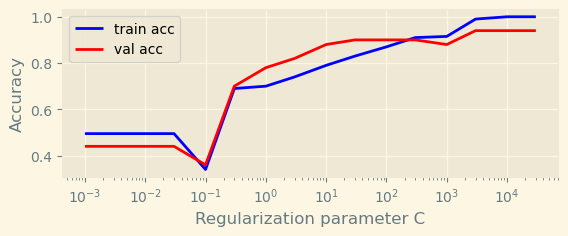

In [25]:
x = [res['reg_C'] for res in results]
train_accs = [res['train_acc'] for res in results]
test_accs = [res['test_acc'] for res in results]
plt.style.use('Solarize_Light2')
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

line1, = ax.plot(x, train_accs, color='blue', lw=2, label="train acc")
line2, = ax.plot(x, test_accs, color='red', lw=2, label="val acc")
plt.xlabel("Regularization parameter C")
plt.ylabel("Accuracy")
ax.set_xscale('log')
plt.legend()
plt.show()

# Load best SVM

In [18]:
loaded_vectorizer = load(config['fitted_models_path'] + "/vectorizer.joblib")
loaded_rbX = load(config['fitted_models_path'] + "/robust_scaler.joblib")
loaded_model = load(config['fitted_models_path'] + "/svm_reg_3000_0.joblib")

In [19]:
# load test data
test_texts = svm_test['text'].values
test_texts = tp.clean_german_texts(test_texts)
test_text_vectors = loaded_vectorizer.transform(test_texts)
test_text_vectors_norm = loaded_rbX.transform(test_text_vectors)
test_labels = svm_test['is_GDPR'].values

In [20]:
test_porbas = loaded_model.predict_proba(test_text_vectors_norm)
test_preds = [np.argmax(prob) for prob in test_porbas]
test_acc = accuracy_score(test_labels, test_preds)

In [21]:
test_acc

0.9

In [22]:
for prob, pred, label in zip(test_porbas, test_preds, test_labels):
    print("{:.4f}, {:.4f}: pred={}, y={}".format(prob[0], prob[1], pred, label))

0.0273, 0.9727: pred=1, y=1
0.8532, 0.1468: pred=0, y=0
0.1569, 0.8431: pred=1, y=1
0.0000, 1.0000: pred=1, y=1
0.2522, 0.7478: pred=1, y=1
0.1567, 0.8433: pred=1, y=1
0.0304, 0.9696: pred=1, y=1
0.1285, 0.8715: pred=1, y=1
0.0141, 0.9859: pred=1, y=1
0.0254, 0.9746: pred=1, y=1
0.5000, 0.5000: pred=0, y=1
0.1560, 0.8440: pred=1, y=1
0.7580, 0.2420: pred=0, y=1
0.0247, 0.9753: pred=1, y=1
0.1439, 0.8561: pred=1, y=1
0.7561, 0.2439: pred=0, y=0
0.0309, 0.9691: pred=1, y=1
0.0000, 1.0000: pred=1, y=1
0.9990, 0.0010: pred=0, y=0
0.9395, 0.0605: pred=0, y=0
0.9992, 0.0008: pred=0, y=0
0.7743, 0.2257: pred=0, y=0
0.9968, 0.0032: pred=0, y=0
0.0695, 0.9305: pred=1, y=1
0.1439, 0.8561: pred=1, y=1
0.6044, 0.3956: pred=0, y=1
0.9926, 0.0074: pred=0, y=0
0.0000, 1.0000: pred=1, y=1
0.0000, 1.0000: pred=1, y=1
0.0541, 0.9459: pred=1, y=1
0.7580, 0.2420: pred=0, y=1
0.0816, 0.9184: pred=1, y=1
0.9560, 0.0440: pred=0, y=0
1.0000, 0.0000: pred=0, y=0
0.8248, 0.1752: pred=0, y=0
0.7839, 0.2161: pred